# Phase 4: Data-Driven Baseline Elo Simulation

**Goal:** Build a control-group simulation using league-specific parameters derived from 10 years of history.

| Step | Cell | Description |
|------|------|-------------|
| Setup | Cell 1 | Load training, banked, and future data |
| Calibration | Cell 2 | Derive league-specific draw rates and home advantage |
| Banked | Cell 3 | Calculate current standings from played 25/26 games |
| Probabilities | Cell 4 | Compute match probabilities for every future fixture |
| Monte Carlo | Cell 5 | Run 10,000-iteration simulation |
| Results | Cell 6 | Aggregate projections + confidence intervals |
| Visualization | Cell 7 | Projected vs Current points chart |

### Inputs
| File | Description |
|------|-------------|
| `model_training.csv` | 10 years of historical match data |
| `current_season_banked.csv` | 25/26 completed matches |
| `future_schedule_features.csv` | 25/26 upcoming fixtures |

### Output
| File | Description |
|------|-------------|
| `data/results/Baseline_Elo_Projection.csv` | Final projected standings with confidence intervals |

In [1]:
# Ensure working directory is the project root perfectly across IDEs/Terminals
import os
import sys
try:
    if 'notebooks' in os.getcwd():
        project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    else:
        project_root = os.getcwd()
    os.chdir(project_root)
    if project_root not in sys.path:
        sys.path.append(project_root)
except Exception:
    pass

# =============================================================================
# Cell 1: Setup & Load Data
# =============================================================================

import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

warnings.filterwarnings('ignore')
np.random.seed(42)

processed_dir = os.path.join('data', 'processed')
results_dir = os.path.join('data', 'results')
os.makedirs(results_dir, exist_ok=True)

n_simulations = 10_000

# --- Load data ---
print('Loading data...')
training = pd.read_csv(os.path.join(processed_dir, 'model_training.csv'),
                       usecols=['league', 'season', 'home_team', 'away_team',
                                'FTHG', 'FTAG', 'FTR', 'home_elo', 'away_elo', 'elo_diff'])
banked = pd.read_csv(os.path.join(processed_dir, 'current_season_banked.csv'))
future = pd.read_csv(os.path.join(processed_dir, 'future_schedule_features.csv'))

print(f'  Training:  {len(training):>7,} rows ({training["season"].nunique()} seasons)')
print(f'  Banked:    {len(banked):>7,} rows (played 25/26 games)')
print(f'  Future:    {len(future):>7,} rows (games to simulate)')

# --- Quick data quality checks ---
assert training['FTR'].isin(['H', 'D', 'A']).all(), 'Invalid FTR values in training'
assert future['home_elo'].notna().all(), 'Missing home_elo in future fixtures'
assert future['away_elo'].notna().all(), 'Missing away_elo in future fixtures'

print('\nData loaded and validated.')

Loading data...
  Training:   19,837 rows (10 seasons)
  Banked:      1,104 rows (played 25/26 games)
  Future:        648 rows (games to simulate)

Data loaded and validated.


In [2]:
# =============================================================================
# Cell 2: Historical Calibration -- League-Specific Constants
# =============================================================================
# Derive draw rates and home advantage from 10 years of data.
# NOT hardcoded -- every value comes from the training set.

print('Calibrating league-specific simulation parameters...')
print('=' * 65)

league_constants = {}

for league in sorted(training['league'].unique()):
    lg = training[training['league'] == league].copy()
    n = len(lg)
    
    # --- Draw Rate ---
    draw_rate = (lg['FTR'] == 'D').mean()
    
    # --- Home Win / Away Win rates ---
    home_win_rate = (lg['FTR'] == 'H').mean()
    away_win_rate = (lg['FTR'] == 'A').mean()
    
    # --- Home Advantage (Elo-derived) ---
    # The home advantage is the additional Elo boost that makes the
    # theoretical Elo model match the observed home win rate.
    # We calculate it as: mean elo_diff in home wins minus mean elo_diff
    # in away wins, divided by 2. This captures how much stronger home
    # teams tend to be beyond raw Elo.
    home_wins = lg[lg['FTR'] == 'H']
    away_wins = lg[lg['FTR'] == 'A']
    
    mean_elo_diff_hw = home_wins['elo_diff'].mean() if len(home_wins) > 0 else 0
    mean_elo_diff_aw = away_wins['elo_diff'].mean() if len(away_wins) > 0 else 0
    
    # Home advantage = half the gap between home-win elo_diff and away-win elo_diff
    home_adv = (mean_elo_diff_hw - mean_elo_diff_aw) / 2
    
    league_constants[league] = {
        'draw_prob': round(draw_rate, 4),
        'home_adv': round(home_adv, 1),
        'home_win_rate': round(home_win_rate, 4),
        'away_win_rate': round(away_win_rate, 4),
        'n_matches': n,
    }
    
    print(f'\n  {league} ({n:,} matches):')
    print(f'    Draw Rate:       {draw_rate:.1%}')
    print(f'    Home Win Rate:   {home_win_rate:.1%}')
    print(f'    Away Win Rate:   {away_win_rate:.1%}')
    print(f'    Home Advantage:  {home_adv:+.1f} Elo points')
    print(f'    Mean Elo Diff (H wins): {mean_elo_diff_hw:+.1f}')
    print(f'    Mean Elo Diff (A wins): {mean_elo_diff_aw:+.1f}')

# --- Summary table ---
print(f'\n{"=" * 65}')
print(f'\nLEAGUE_CONSTANTS summary:')
print(f'{"League":30s} {"Draw%":>6s} {"HomeAdv":>8s} {"H%":>6s} {"A%":>6s}')
print('-' * 58)
for lg, c in sorted(league_constants.items()):
    print(f'{lg:30s} {c["draw_prob"]:6.1%} {c["home_adv"]:+7.1f} {c["home_win_rate"]:6.1%} {c["away_win_rate"]:6.1%}')

Calibrating league-specific simulation parameters...

  ENG-Premier League (4,180 matches):
    Draw Rate:       23.3%
    Home Win Rate:   44.1%
    Away Win Rate:   32.6%
    Home Advantage:  +76.2 Elo points
    Mean Elo Diff (H wins): +68.4
    Mean Elo Diff (A wins): -84.0

  ESP-La Liga (4,180 matches):
    Draw Rate:       25.9%
    Home Win Rate:   45.2%
    Away Win Rate:   28.9%
    Home Advantage:  +80.1 Elo points
    Mean Elo Diff (H wins): +68.0
    Mean Elo Diff (A wins): -92.2

  FRA-Ligue 1 (3,931 matches):
    Draw Rate:       25.2%
    Home Win Rate:   43.4%
    Away Win Rate:   31.3%
    Home Advantage:  +59.9 Elo points
    Mean Elo Diff (H wins): +53.9
    Mean Elo Diff (A wins): -65.8

  GER-Bundesliga (3,366 matches):
    Draw Rate:       25.1%
    Home Win Rate:   44.1%
    Away Win Rate:   30.7%
    Home Advantage:  +66.7 Elo points
    Mean Elo Diff (H wins): +54.7
    Mean Elo Diff (A wins): -78.8

  ITA-Serie A (4,180 matches):
    Draw Rate:       26.0%
  

In [3]:
# =============================================================================
# Cell 3: Banked Points -- Current 25/26 Standings
# =============================================================================

print('Calculating banked points from completed 25/26 matches...')
print('=' * 65)

def calc_standings(df):
    """Calculate league standings from match results."""
    records = []
    
    for _, row in df.iterrows():
        home = row['home_team']
        away = row['away_team']
        league = row['league']
        ftr = row['FTR']
        hg = row['FTHG']
        ag = row['FTAG']
        
        if ftr == 'H':
            records.append({'team': home, 'league': league, 'pts': 3, 'w': 1, 'd': 0, 'l': 0, 'gf': hg, 'ga': ag, 'mp': 1})
            records.append({'team': away, 'league': league, 'pts': 0, 'w': 0, 'd': 0, 'l': 1, 'gf': ag, 'ga': hg, 'mp': 1})
        elif ftr == 'D':
            records.append({'team': home, 'league': league, 'pts': 1, 'w': 0, 'd': 1, 'l': 0, 'gf': hg, 'ga': ag, 'mp': 1})
            records.append({'team': away, 'league': league, 'pts': 1, 'w': 0, 'd': 1, 'l': 0, 'gf': ag, 'ga': hg, 'mp': 1})
        elif ftr == 'A':
            records.append({'team': home, 'league': league, 'pts': 0, 'w': 0, 'd': 0, 'l': 1, 'gf': hg, 'ga': ag, 'mp': 1})
            records.append({'team': away, 'league': league, 'pts': 3, 'w': 1, 'd': 0, 'l': 0, 'gf': ag, 'ga': hg, 'mp': 1})
    
    standings = pd.DataFrame(records)
    standings = standings.groupby(['team', 'league']).sum().reset_index()
    standings['gd'] = standings['gf'] - standings['ga']
    standings = standings.sort_values(['league', 'pts', 'gd'], ascending=[True, False, False])
    return standings

banked_standings = calc_standings(banked)

print(f'\nBanked standings calculated for {banked_standings["team"].nunique()} teams across {banked_standings["league"].nunique()} leagues.')

for league in sorted(banked_standings['league'].unique()):
    lg = banked_standings[banked_standings['league'] == league].head(5)
    print(f'\n  {league} -- Top 5:')
    print(f'  {"Team":22s} {"MP":>3s} {"W":>3s} {"D":>3s} {"L":>3s} {"GD":>4s} {"Pts":>4s}')
    print(f'  {"-"*45}')
    for _, r in lg.iterrows():
        print(f'  {r["team"]:22s} {int(r["mp"]):3d} {int(r["w"]):3d} {int(r["d"]):3d} {int(r["l"]):3d} {int(r["gd"]):+4d} {int(r["pts"]):4d}')

Calculating banked points from completed 25/26 matches...

Banked standings calculated for 96 teams across 5 leagues.

  ENG-Premier League -- Top 5:
  Team                    MP   W   D   L   GD  Pts
  ---------------------------------------------
  Arsenal                 26  17   6   3  +32   57
  Man City                26  16   5   5  +30   53
  Aston Villa             26  15   5   6  +10   50
  Man United              26  12   9   5  +10   45
  Chelsea                 26  12   8   6  +17   44

  ESP-La Liga -- Top 5:
  Team                    MP   W   D   L   GD  Pts
  ---------------------------------------------
  Barcelona               23  19   1   3  +40   58
  Real Madrid             23  18   3   2  +31   57
  Ath Madrid              23  13   6   4  +20   45
  Villarreal              22  14   3   5  +19   45
  Betis                   23  10   8   5   +9   38

  FRA-Ligue 1 -- Top 5:
  Team                    MP   W   D   L   GD  Pts
  ---------------------------------------

In [4]:
# =============================================================================
# Cell 4: Match Probability Engine
# =============================================================================
# For every future fixture, compute P(Home), P(Draw), P(Away) using
# the calibrated league-specific constants.

print('Computing match probabilities for future fixtures...')
print('=' * 65)

sim_df = future[['league', 'home_team', 'away_team', 'home_elo', 'away_elo', 'date_norm']].copy()

# Map league constants
sim_df['draw_prob'] = sim_df['league'].map(lambda x: league_constants[x]['draw_prob'])
sim_df['home_adv']  = sim_df['league'].map(lambda x: league_constants[x]['home_adv'])

# --- Elo-based probability formula ---
# P(Home)_raw = 1 / (10^(-(HomeElo - AwayElo + HomeAdv) / 400) + 1)
elo_gap = sim_df['home_elo'] - sim_df['away_elo'] + sim_df['home_adv']
sim_df['p_home_raw'] = 1.0 / (10.0 ** (-elo_gap / 400.0) + 1.0)

# --- Draw adjustment ---
# Carve out the draw probability, then scale H and A proportionally
sim_df['p_home'] = sim_df['p_home_raw'] * (1.0 - sim_df['draw_prob'])
sim_df['p_draw'] = sim_df['draw_prob']
sim_df['p_away'] = 1.0 - sim_df['p_home'] - sim_df['p_draw']

# --- Validate probabilities ---
prob_sum = sim_df[['p_home', 'p_draw', 'p_away']].sum(axis=1)
assert np.allclose(prob_sum, 1.0), f'Probabilities do not sum to 1.0: {prob_sum.describe()}'
assert (sim_df['p_away'] >= 0).all(), 'Negative away probabilities detected'

print(f'  Fixtures to simulate: {len(sim_df)}')
print(f'  Probability ranges:')
print(f'    P(Home): {sim_df["p_home"].min():.3f} - {sim_df["p_home"].max():.3f} (mean: {sim_df["p_home"].mean():.3f})')
print(f'    P(Draw): {sim_df["p_draw"].min():.3f} - {sim_df["p_draw"].max():.3f} (mean: {sim_df["p_draw"].mean():.3f})')
print(f'    P(Away): {sim_df["p_away"].min():.3f} - {sim_df["p_away"].max():.3f} (mean: {sim_df["p_away"].mean():.3f})')
print(f'    Sum check: all rows sum to 1.0 [PASS]')

# --- Show example matchups ---
print(f'\n  Sample fixtures with probabilities:')
sample = sim_df[['league', 'home_team', 'away_team', 'p_home', 'p_draw', 'p_away']].head(8)
print(sample.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

Computing match probabilities for future fixtures...
  Fixtures to simulate: 648
  Probability ranges:
    P(Home): 0.085 - 0.713 (mean: 0.444)
    P(Draw): 0.233 - 0.260 (mean: 0.252)
    P(Away): 0.036 - 0.662 (mean: 0.304)
    Sum check: all rows sum to 1.0 [PASS]

  Sample fixtures with probabilities:
            league      home_team   away_team  p_home  p_draw  p_away
ENG-Premier League    Aston Villa       Leeds   0.602   0.233   0.165
ENG-Premier League      Brentford    Brighton   0.500   0.233   0.267
ENG-Premier League        Chelsea     Burnley   0.653   0.233   0.114
ENG-Premier League       West Ham Bournemouth   0.359   0.233   0.408
ENG-Premier League       Man City   Newcastle   0.567   0.233   0.200
ENG-Premier League Crystal Palace      Wolves   0.580   0.233   0.187
ENG-Premier League  Nott'm Forest   Liverpool   0.280   0.233   0.487
ENG-Premier League     Sunderland      Fulham   0.357   0.233   0.410


In [5]:
# =============================================================================
# Cell 5: Monte Carlo Simulation (10,000 iterations)
# =============================================================================

print(f'Running {n_simulations:,} Monte Carlo iterations...')
print('=' * 65)

n_fixtures = len(sim_df)
probs = sim_df[['p_home', 'p_draw', 'p_away']].values  # (n_fixtures, 3)

# Get unique teams per league
team_leagues = {}
for _, row in sim_df.iterrows():
    team_leagues[row['home_team']] = row['league']
    team_leagues[row['away_team']] = row['league']

all_teams = sorted(team_leagues.keys())
team_idx = {t: i for i, t in enumerate(all_teams)}
n_teams = len(all_teams)

# Precompute fixture -> team index mapping
home_indices = np.array([team_idx[t] for t in sim_df['home_team']])
away_indices = np.array([team_idx[t] for t in sim_df['away_team']])

# --- Simulate ---
# points_matrix: (n_simulations, n_teams)
points_matrix = np.zeros((n_simulations, n_teams), dtype=np.int32)

for sim in range(n_simulations):
    # Generate random outcomes for all fixtures at once
    rands = np.random.random(n_fixtures)
    
    # Determine outcomes: H if rand < p_home, D if rand < p_home + p_draw, else A
    cum_home = probs[:, 0]
    cum_draw = probs[:, 0] + probs[:, 1]
    
    home_win = rands < cum_home
    draw = (rands >= cum_home) & (rands < cum_draw)
    away_win = rands >= cum_draw
    
    # Home wins: home gets 3 pts
    np.add.at(points_matrix[sim], home_indices[home_win], 3)
    
    # Draws: both get 1 pt
    np.add.at(points_matrix[sim], home_indices[draw], 1)
    np.add.at(points_matrix[sim], away_indices[draw], 1)
    
    # Away wins: away gets 3 pts
    np.add.at(points_matrix[sim], away_indices[away_win], 3)
    
    if (sim + 1) % 2500 == 0:
        print(f'  Completed {sim + 1:>6,} / {n_simulations:,} iterations')

print(f'\nSimulation complete.')
print(f'  Points matrix shape: {points_matrix.shape}')
print(f'  Mean simulated points per team: {points_matrix.mean():.1f}')

Running 10,000 Monte Carlo iterations...
  Completed  2,500 / 10,000 iterations
  Completed  5,000 / 10,000 iterations
  Completed  7,500 / 10,000 iterations
  Completed 10,000 / 10,000 iterations

Simulation complete.
  Points matrix shape: (10000, 96)
  Mean simulated points per team: 18.5


In [6]:
# =============================================================================
# Cell 6: Results & Projections
# =============================================================================

print('Aggregating simulation results...')
print('=' * 65)

# --- Simulated points statistics ---
sim_mean = points_matrix.mean(axis=0)
sim_p5   = np.percentile(points_matrix, 5, axis=0)
sim_p25  = np.percentile(points_matrix, 25, axis=0)
sim_p75  = np.percentile(points_matrix, 75, axis=0)
sim_p95  = np.percentile(points_matrix, 95, axis=0)

sim_results = pd.DataFrame({
    'team': all_teams,
    'league': [team_leagues[t] for t in all_teams],
    'sim_pts_mean': np.round(sim_mean, 1),
    'sim_pts_p5':   sim_p5,
    'sim_pts_p25':  sim_p25,
    'sim_pts_p75':  sim_p75,
    'sim_pts_p95':  sim_p95,
})

# --- Merge with banked points ---
projection = banked_standings[['team', 'league', 'pts', 'mp', 'w', 'd', 'l', 'gd']].merge(
    sim_results,
    on=['team', 'league'],
    how='outer'
)

# Fill any teams that are only in future (promoted, no banked games yet)
projection['pts'] = projection['pts'].fillna(0).astype(int)
projection['mp'] = projection['mp'].fillna(0).astype(int)
projection['sim_pts_mean'] = projection['sim_pts_mean'].fillna(0)

# --- Projected total ---
projection['projected_pts'] = projection['pts'] + projection['sim_pts_mean']
projection['projected_p5']  = projection['pts'] + projection['sim_pts_p5']
projection['projected_p95'] = projection['pts'] + projection['sim_pts_p95']

# Sort by league and projected points
projection = projection.sort_values(['league', 'projected_pts'], ascending=[True, False])

# Add projected rank within league
projection['rank'] = projection.groupby('league')['projected_pts'].rank(ascending=False, method='min').astype(int)

# --- Save ---
output_path = os.path.join(results_dir, 'Baseline_Elo_Projection.csv')
projection.to_csv(output_path, index=False)
print(f'\nSaved: {output_path}')
print(f'  {len(projection)} teams across {projection["league"].nunique()} leagues')

# --- Display per league ---
for league in sorted(projection['league'].unique()):
    lg = projection[projection['league'] == league].head(8)
    print(f'\n  {league}:')
    print(f'  {"#":>2s} {"Team":22s} {"Banked":>7s} {"Sim":>6s} {"Proj":>6s} {"5%":>6s} {"95%":>6s}')
    print(f'  {"-"*56}')
    for _, r in lg.iterrows():
        print(f'  {int(r["rank"]):2d} {r["team"]:22s} {int(r["pts"]):7d} {r["sim_pts_mean"]:+6.1f} {r["projected_pts"]:6.1f} {r["projected_p5"]:6.0f} {r["projected_p95"]:6.0f}')

# --- Validation ---
print(f'\n{"=" * 65}')
print('Validation:')
all_positive = (projection['projected_pts'] >= projection['pts']).all()
print(f'  Projected >= Banked for all teams: {"[PASS]" if all_positive else "[FAIL]"}')
ci_ordered = (projection['projected_p5'] <= projection['projected_p95']).all()
print(f'  5th percentile <= 95th percentile: {"[PASS]" if ci_ordered else "[FAIL]"}')
all_leagues = projection['league'].nunique() == 5
print(f'  All 5 leagues present:             {"[PASS]" if all_leagues else "[FAIL]"}')

Aggregating simulation results...

Saved: data\results\Baseline_Elo_Projection.csv
  96 teams across 5 leagues

  ENG-Premier League:
   # Team                    Banked    Sim   Proj     5%    95%
  --------------------------------------------------------
   1 Arsenal                     57  +24.6   81.6     75     88
   2 Man City                    53  +21.4   74.4     67     82
   3 Aston Villa                 50  +20.9   70.9     64     78
   4 Liverpool                   42  +21.2   63.2     56     70
   5 Man United                  45  +17.8   62.8     55     70
   6 Chelsea                     44  +18.7   62.7     56     70
   7 Brentford                   40  +18.1   58.1     51     65
   8 Bournemouth                 37  +17.2   54.2     47     61

  ESP-La Liga:
   # Team                    Banked    Sim   Proj     5%    95%
  --------------------------------------------------------
   1 Barcelona                   58  +30.6   88.6     81     96
   2 Real Madrid            

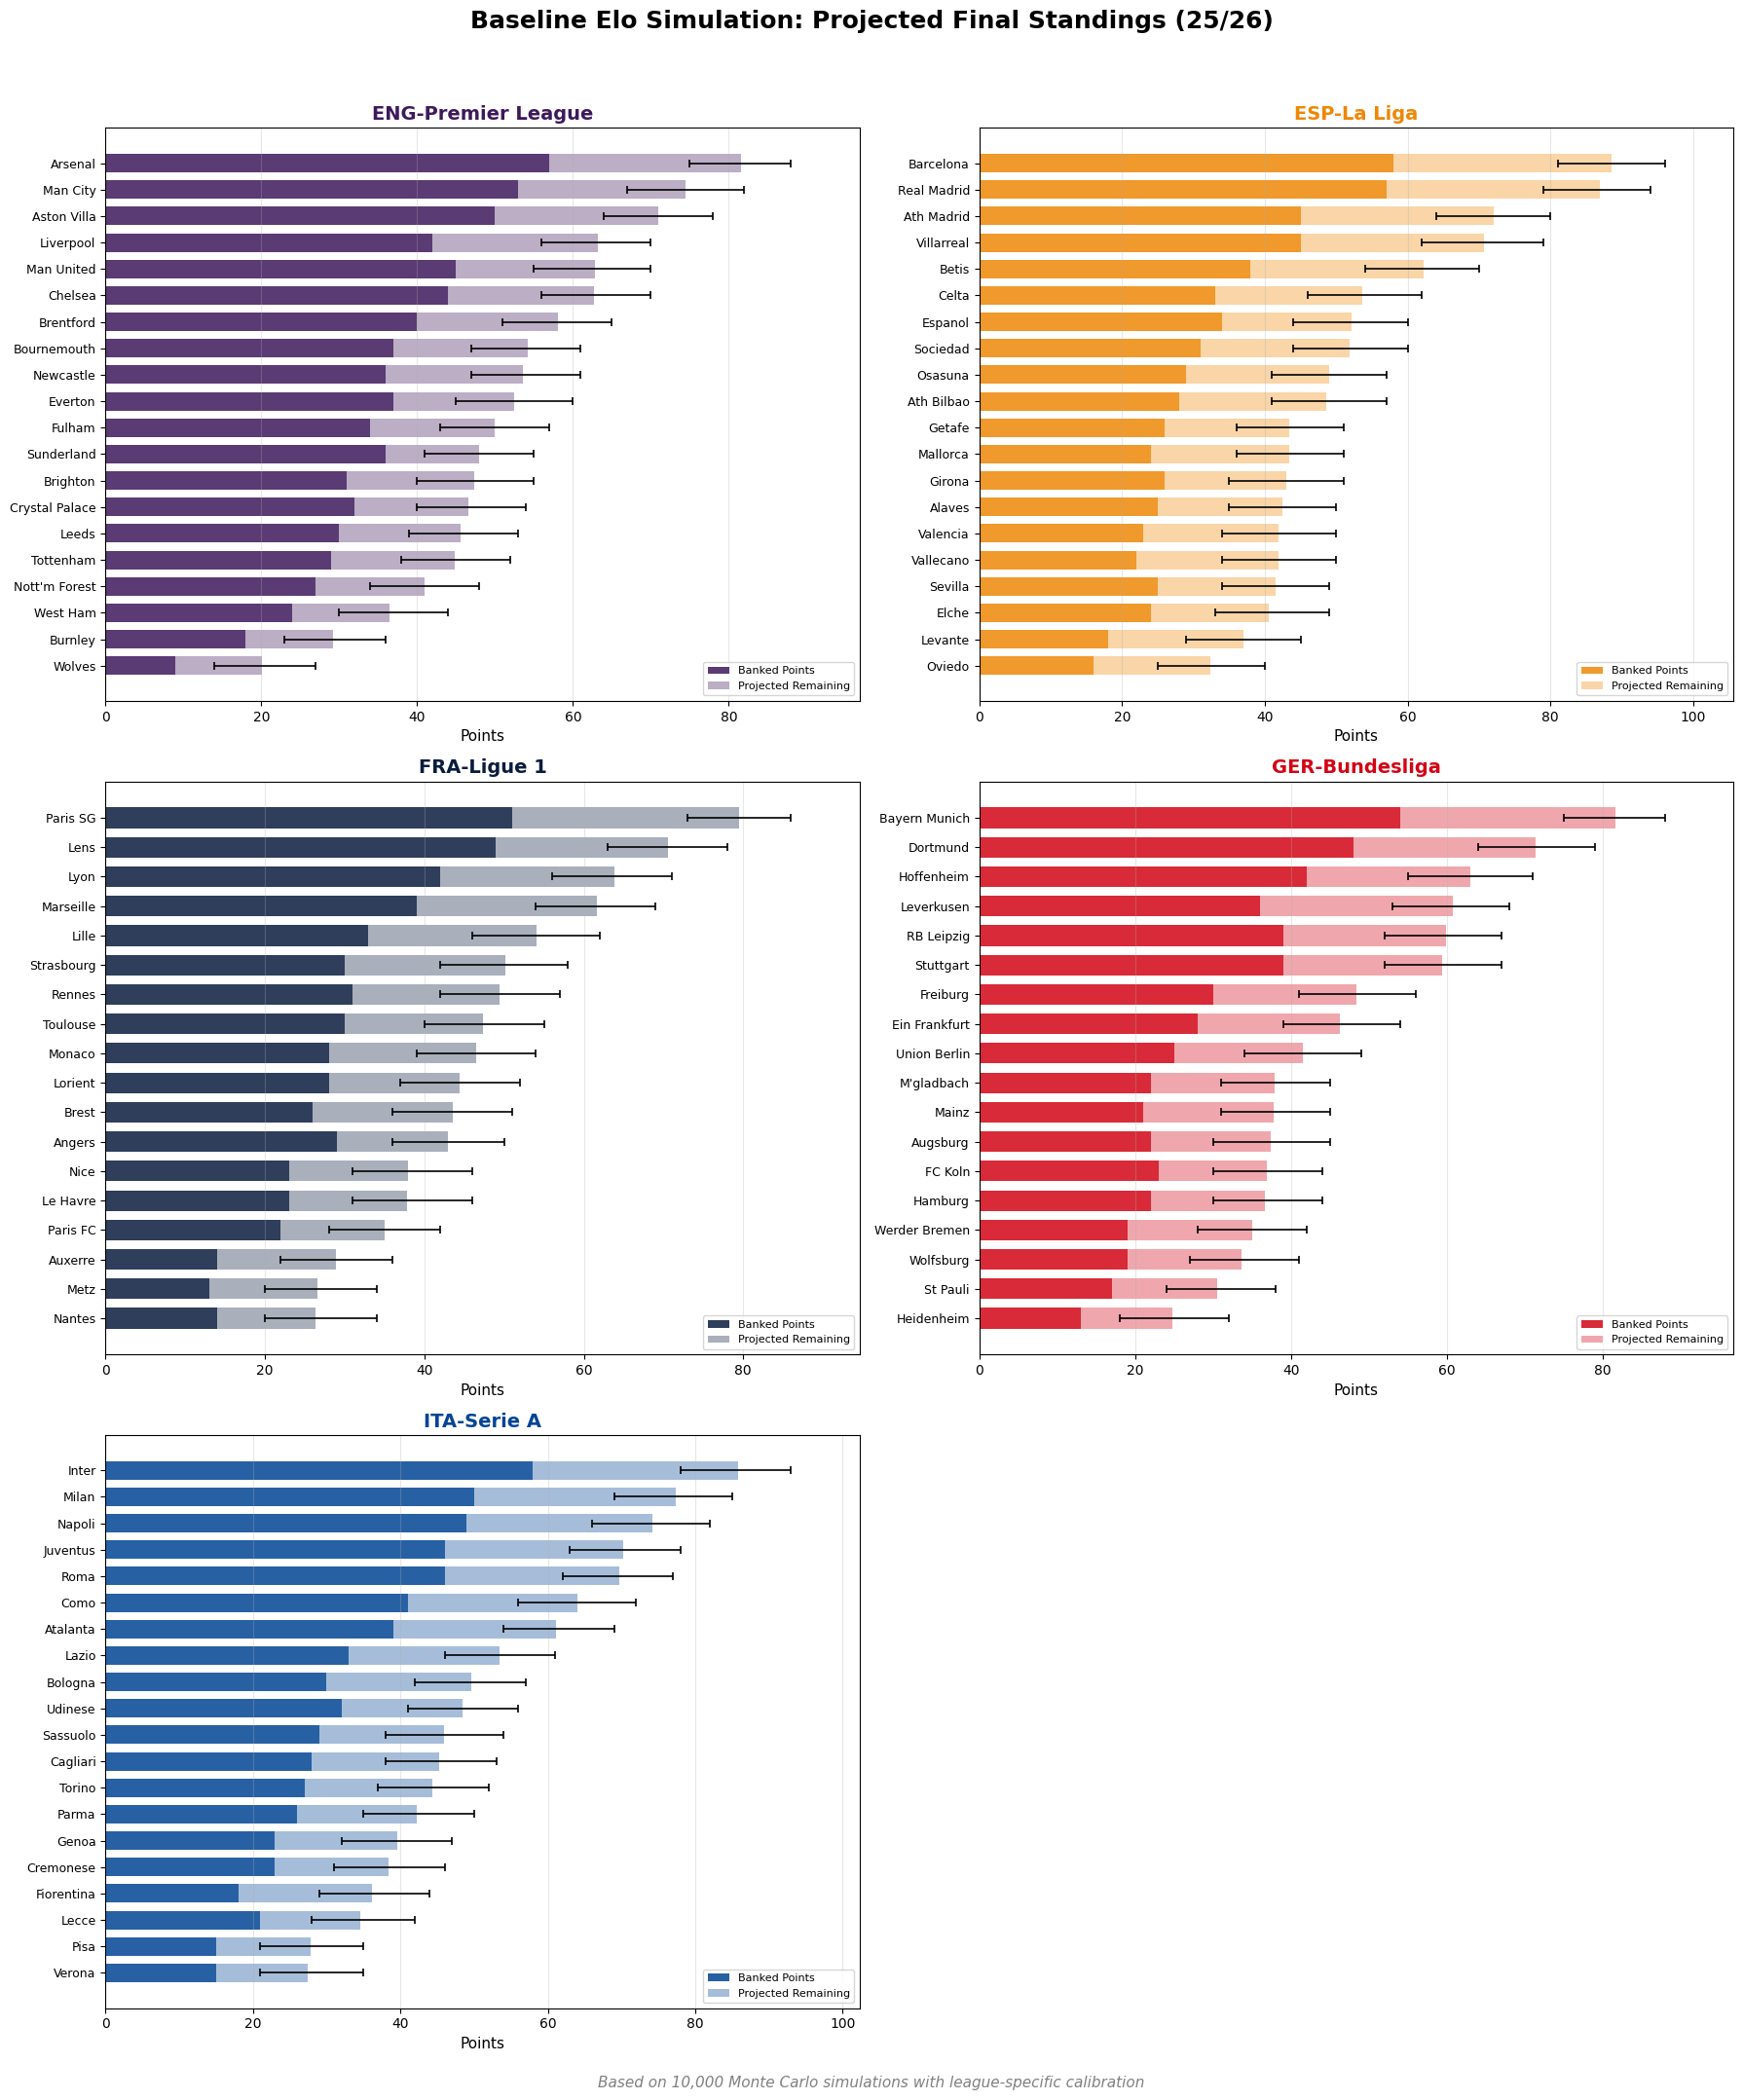


Chart saved: data\results\Baseline_Elo_Projection.png
Phase 4 complete.


In [7]:
# =============================================================================
# Cell 7: Visualization -- Projected vs Current Points
# =============================================================================

league_colors = {
    'ENG-Premier League': '#3d195b',
    'ESP-La Liga':        '#ee8707',
    'GER-Bundesliga':     '#d20515',
    'ITA-Serie A':        '#024494',
    'FRA-Ligue 1':        '#091c3e',
}

fig, axes = plt.subplots(3, 2, figsize=(18, 22))
axes = axes.flatten()

for idx, league in enumerate(sorted(projection['league'].unique())):
    ax = axes[idx]
    lg = projection[projection['league'] == league].sort_values('projected_pts', ascending=True)
    
    color = league_colors.get(league, '#333333')
    n_teams = len(lg)
    y_pos = np.arange(n_teams)
    
    # Banked points (solid bar)
    ax.barh(y_pos, lg['pts'].values, height=0.7, color=color, alpha=0.85, label='Banked Points')
    
    # Simulated points (lighter extension)
    ax.barh(y_pos, lg['sim_pts_mean'].values, height=0.7, left=lg['pts'].values,
            color=color, alpha=0.35, label='Projected Remaining')
    
    # Confidence interval whiskers
    ax.errorbar(
        lg['projected_pts'].values, y_pos,
        xerr=[lg['projected_pts'].values - lg['projected_p5'].values,
              lg['projected_p95'].values - lg['projected_pts'].values],
        fmt='none', ecolor='black', elinewidth=1.2, capsize=3, capthick=1.2
    )
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(lg['team'].values, fontsize=9)
    ax.set_xlabel('Points', fontsize=11)
    ax.set_title(league, fontsize=14, fontweight='bold', color=color)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, lg['projected_p95'].max() * 1.1)

# Hide the 6th subplot (we have 5 leagues)
axes[5].set_visible(False)

fig.suptitle('Baseline Elo Simulation: Projected Final Standings (25/26)',
             fontsize=18, fontweight='bold', y=0.98)
fig.text(0.5, 0.01, f'Based on {n_simulations:,} Monte Carlo simulations with league-specific calibration',
         ha='center', fontsize=11, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.savefig(os.path.join(results_dir, 'Baseline_Elo_Projection.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'\nChart saved: {os.path.join(results_dir, "Baseline_Elo_Projection.png")}')
print('Phase 4 complete.')